In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
prof_file_path = "Data/clean_prof_info.csv"
comment_file_path = "Data/clean_ratings.csv"


In [5]:
df_prof = pd.read_csv(prof_file_path)
df_comment = pd.read_csv(comment_file_path, parse_dates=["date"])

## Introduction

In this project, we analyze a dataset that contains information about University of Michigan professor ratings. More specifically, we want to build a machine learning model that studies the sentiment conveyed by the comments student gave to professors and use it to predict the sentiment of new comments. 

In [120]:
df_comment.head()

,profID,attendanceMandatory,class,comment,date,difficultyRating,grade,helpfulRating,isForCredit,isForOnlineClass,ratingTags,wouldTakeAgain
0,7964,False,ANTHRCUL101,Fricke is the man. Entire class probably took ...,2019-04-28 17:13:12,1.0,A,5.0,False,False,"['Respected', 'Inspirational', 'Amazing Lectur...",True
1,7964,False,ANTHRO101,Tom Fricke is one of those professors you will...,2019-01-08 18:41:24,1.0,A+,5.0,False,False,"['Accessible Outside Class', 'Hilarious', 'Ama...",True
2,7964,False,ANTHRCUL101,Prof. Fricke is amazing. He is hilarious and t...,2018-12-16 03:11:18,1.0,A,5.0,False,False,"['Hilarious', 'Graded By Few Things', 'Caring']",True
3,7964,False,CULTANTHRO101,Such an easy class. Exams were exactly like th...,2018-12-12 10:03:19,1.0,A,5.0,False,False,"['Accessible Outside Class', 'Graded By Few Th...",True
4,7964,False,ANTHRCUL101,Easiest class i have taken at UM. The exams to...,2018-12-11 16:33:00,1.0,A+,5.0,False,False,"['Respected', 'Hilarious', 'Amazing Lectures']",True


## Data

The source of the data is from [Rate My Professor](https://www.ratemyprofessors.com/search/teachers?query=*&sid=1258), a website where students can give anoymous and objective opinions about their professors. To gather out dataset, we took several steps.

### Step One
First, we want to know how many UofM professors are recorded on the website. In particular, we want to find a list of professor IDs. In order to do this, we find all professors in UofM by applying school filter on the website. There are more than 5000 unique results for UofM professors. However, not all results were shown. We need to keep on clicking "Show More" button on the website to show more result. To do this more easily, we wrote a script "scraper.py" that utilizes python selenium library to click the button for us. The process of parsing the IDs were not very smooth. The script was interrupted a couple time due to denial of service by the website. We ended up parsing over 3000 professor IDs. 

### Step Two
After getting professor IDs, we were able to retrieve other information as well. In data_acquisition.py, we iteratively made POST requests to the ratemyprofessor.com to retrieve raw information such as comments, ratings, subject name, and professor names. Then we did some data cleaning in data_cleaning.ipynb and put separated data into two CSV files: clean_prof_info.csv and clean_ratings.csv. clean_prof_info.csv contains 4612 rows and 8 columns of data:

```profID```: Professor IDs.  
```avgDifficulty```: Average diffculty score rated for a professor.  
```avgRating```: Average rating for a professor.  
```department```: The department a professor is from.  
```firstName```: Professor's first name.  
```lastName```: Professor's last name.  
```numRatings```: Number of ratings this professor has.  
```wouldTakeAgainPercent```: Percent of students who rated this professor that would take the his/hers class again.  
```fullName```: Professor's full name.  

clean_ratings.csv contains 52245 rows and 12 columns of data:

```profID```: Professor IDs.  
```attendanceMandatory```: Whether a class is mandatory for attendance.  
```class```: The class number.  
```comment```: The comment student wrote.  
```date```: The data the comment was wrote.  
```difficultyRating```: The difficulty of the class given by the student.  
```grade```: Student's grade in that class.  
```helpfulRating```: How helpful student think the professor was.  
```isForCredit```: Is the class for credit.  
```isForOnlineClass```: Is class remote.  
```ratingTags```: Tags given by the student.  
```wouldTakeAgain```: If the student would take the class again.  




### Interesting Data Samples

First sample we examine utilizes data from 10 department with highest number of ratings. We think this sample would be useful because we would later build a machine learning model that examines whether the sentiment of a comment is positive or negative; the rating given by the students matter in this case since the rating score ranges fromn 1-5 with a segment of 0.1, the score itself is also objective, thus, we could need a boundry to define whether the sentiment under a particular range of ratings is positive, neutral, or negative. 

We decided to pick 10 department with highest number of rating because they have a rather complete data sample with a variety of ranges. The median of the rating is 3.9, which can be used as a general boundry. However, such use of boundry can be not representative in some cases as there are bias among university department. For instance, one department is less funded than another, resulting in fewer teaching resources and utimately led to bad ratings. 

Another interesting observation can be made from the box-plot. If we divide department into STEM group (subject related to science, technology, engineering, and mathematics) and non STEM group (in this case that would be Psychology, English, Social Work, Spanish, Political Science, and History), we noticed that STEM group has a noticable lower rating on average than non STEM group (median of 3.6 comparing to a median of 4.0).

In [14]:
df_depart = df_prof['department'].value_counts()
top_depart = df_depart.head(10).index.tolist()
departs = df_prof[df_prof['department'].isin(top_depart)]
departs = departs[['department', 'avgRating']]
depart_sorted = departs.sort_values('avgRating', ascending=False)

stem = ['Mathematics', 'Economics', 'Chemistry', 'Biology']

depart_sorted.median()
depart_sorted[depart_sorted['department'].isin(stem)].median()
depart_sorted[~depart_sorted['department'].isin(stem)].median()

/tmp/ipykernel_1851/1109509292.py:9: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  depart_sorted.median()
/tmp/ipykernel_1851/1109509292.py:10: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  depart_sorted[depart_sorted['department'].isin(stem)].median()
/tmp/ipykernel_1851/1109509292.py:11: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of n

avgRating    4.0
dtype: float64

<AxesSubplot: xlabel='avgRating', ylabel='department'>

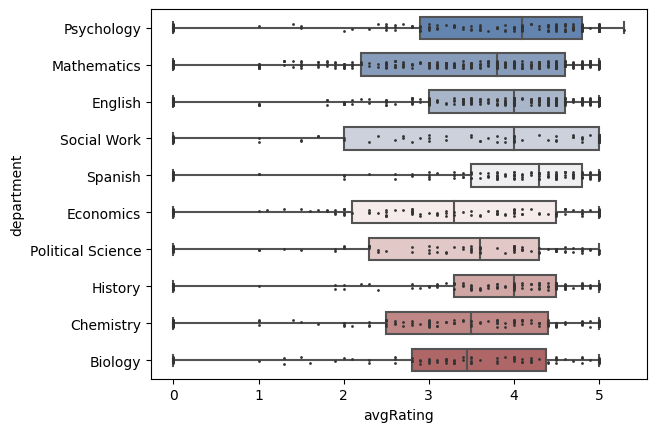

In [115]:

sns.boxplot(x='avgRating', y='department', data=depart_sorted, whis=[0, 100], width=0.6, palette='vlag')
sns.stripplot(x='avgRating', y='department', data=depart_sorted, size=2, color='0.2', linewidth=0)

In [111]:
departs.groupby('department').mean().sort_values('avgRating', ascending=False)

,avgRating
department,
Spanish,3.802516
Psychology,3.523243
History,3.509231
English,3.449451
Social Work,3.294737
Mathematics,3.252506
Biology,3.227660
Chemistry,3.161702
Economics,3.144444
